Based on: https://github.com/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/cmip6_zarr.ipynb

This notebook demonstrates how to work with the CMIP6 Zarr data available as part of the AWS Open Data Program (https://registry.opendata.aws/cmip6/).

THIS ONE HERE IS ADAPTED TO A LOCAL CLUSTER

In [1]:
from dask.distributed import Client, LocalCluster, performance_report, progress
cluster = LocalCluster()
client = Client(cluster)

In [2]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.64 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39701,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.64 GiB
Comm: tcp://127.0.0.1:38471,Total threads: 2
Dashboard: http://127.0.0.1:35091/status,Memory: 3.91 GiB
Nanny: tcp://127.0.0.1:38959,


In [3]:
%pip install boto3 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.1.0 requires botocore<1.23.25,>=1.23.24, but you have botocore 1.24.21 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install xarray -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask

In [6]:
@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 50})
    return s3fs.S3Map(path, s3=fs)

Note that the below process is extremely inefficient on a local computer outside aws, as it has to download and process the dataset every time an operation is performed. It would be better to run the notebook on AWS or download the data locally.
Nonetheless, Dask can parallelize the downloading and processing of data.

In [7]:
%%time
files_mapper = [s3open('s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp119/r1i1p1f1/day/tas/gr1/v20180701/')]
ds = xr.open_mfdataset(files_mapper, engine='zarr', parallel=True, decode_times=False)

CPU times: user 160 ms, sys: 48 ms, total: 208 ms
Wall time: 2.33 s


In [8]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 6.51



<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 31390)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 ... 31384 31385 31386 31387 31388 31389
    time_bnds  (time, bnds) float64 dask.array<chunksize=(15695, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(421, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  6

In [9]:
ds['tas'] = (ds.tas - 273.15) * 9.0 / 5.0 + 32.0
ds.tas.attrs['units'] = 'F'

In [11]:
# calculates the mean along the time dimension
temp_mean = ds['tas'].mean(dim='time')

In [12]:
temp_mean = temp_mean.persist()
progress(temp_mean)

VBox()

Text(0.5, 1.0, '2015-2100 Mean 2-m Air Temperature')

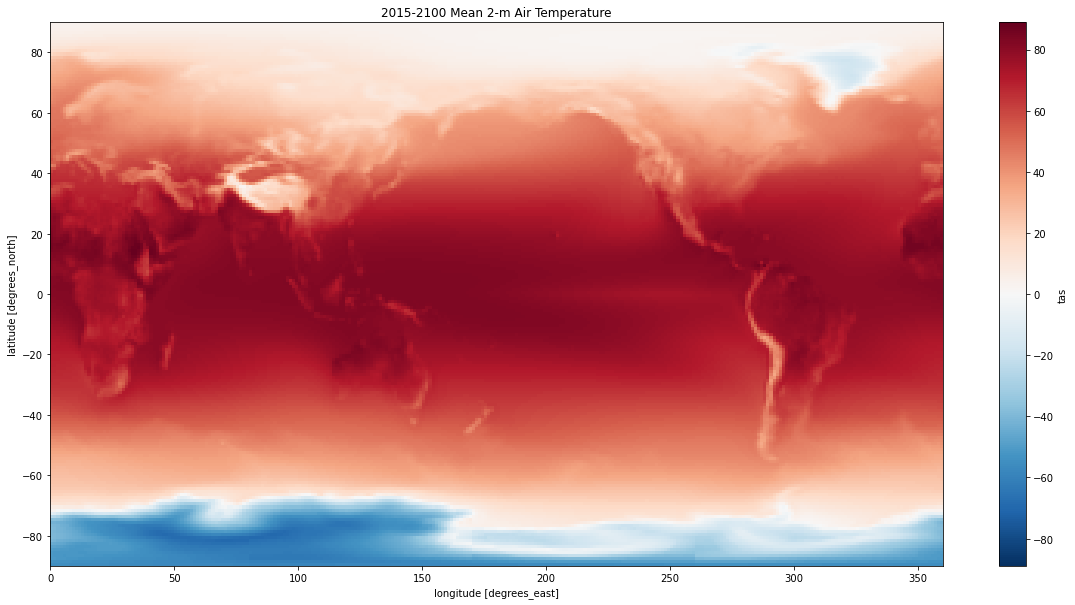

In [13]:
temp_mean.compute()
temp_mean.plot(figsize=(20, 10))
plt.title('2015-2100 Mean 2-m Air Temperature')

In [10]:
temp_std = ds['tas'].std(dim='time')

Running the task below crashed the workers when using 8GB of RAM. I switched Docker to 16GB and 2GB swap to be able to run it, though probably 12GB would be sufficient, as the task was almost completed with 8GB.

In [13]:
%time temp_std = temp_std.compute()

CPU times: user 175 µs, sys: 31 µs, total: 206 µs
Wall time: 209 µs


In [12]:
temp_std

<xarray.DataArray 'tas' (lat: 180, lon: 288)>
array([[19.785145, 19.794588, 19.804071, ..., 19.75707 , 19.766386,
        19.775745],
       [19.515213, 19.528969, 19.543001, ..., 19.475588, 19.488523,
        19.501732],
       [19.44569 , 19.45964 , 19.474438, ..., 19.408997, 19.420359,
        19.432592],
       ...,
       [23.58417 , 23.55908 , 23.534788, ..., 23.664276, 23.636768,
        23.610065],
       [23.669882, 23.655731, 23.641895, ..., 23.714216, 23.69913 ,
        23.68435 ],
       [23.797152, 23.793783, 23.790462, ..., 23.807531, 23.804022,
        23.800564]], dtype=float32)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

Text(0.5, 1.0, '2015-2100 Standard Deviation 2-m Air Temperature')

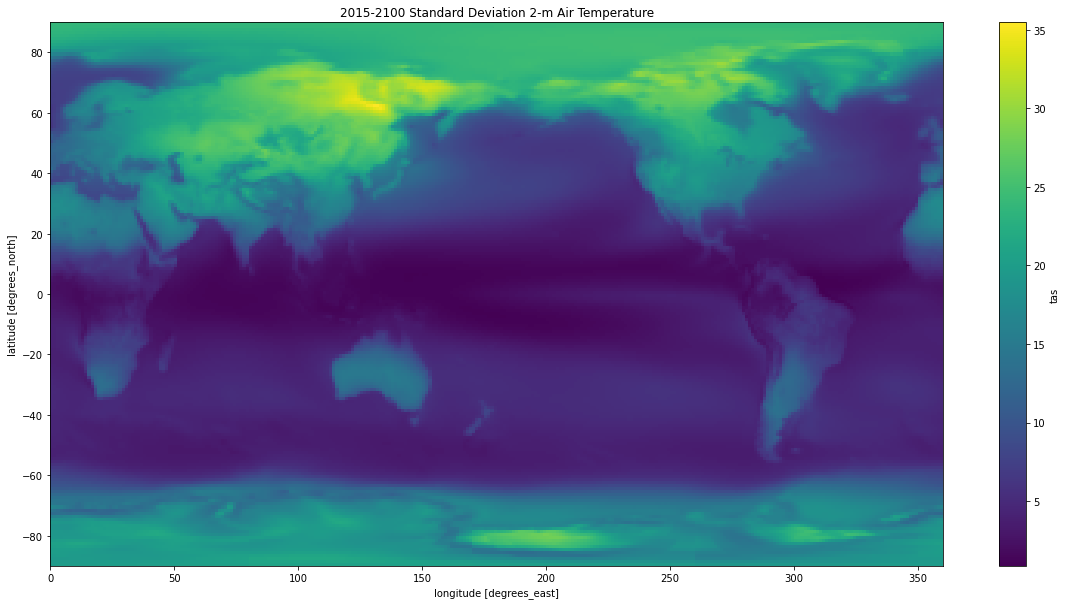

In [14]:
temp_std.plot(figsize=(20, 10))
plt.title('2015-2100 Standard Deviation 2-m Air Temperature')

In [15]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [16]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'tas' : var_name}).drop(('lat', 'lon', 'height', 'lat_bnds', 'lon_bnds'))

    ds_locs = xr.merge([ds_locs, ds2], compat='override')

ds_locs.data_vars

Data variables:
    Santa Barbara     (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Colorado Springs  (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Honolulu          (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Seattle           (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>

The long time was due to successive reads of the dataset from the remote source

In [17]:
%%time
df_f = ds_locs.to_dataframe()
df_f.describe()

CPU times: user 1min 5s, sys: 8.76 s, total: 1min 14s
Wall time: 11min 4s


,Santa Barbara,time_bnds,Colorado Springs,Honolulu,Seattle
count,62780.000000,62780.000000,62780.000000,62780.000000,62780.000000
mean,61.857880,75920.000000,49.709137,75.883705,46.186661
std,11.264415,9061.584654,18.002907,3.517426,11.514710
min,30.185278,60225.000000,-3.966026,62.430756,-3.104340
25%,52.528065,68072.750000,35.121765,73.393410,37.788750
50%,60.398972,75920.000000,47.668564,75.938087,45.599756
75%,71.497169,83767.250000,65.013535,78.844604,55.601765
max,93.166054,91615.000000,89.571434,84.897247,77.280922


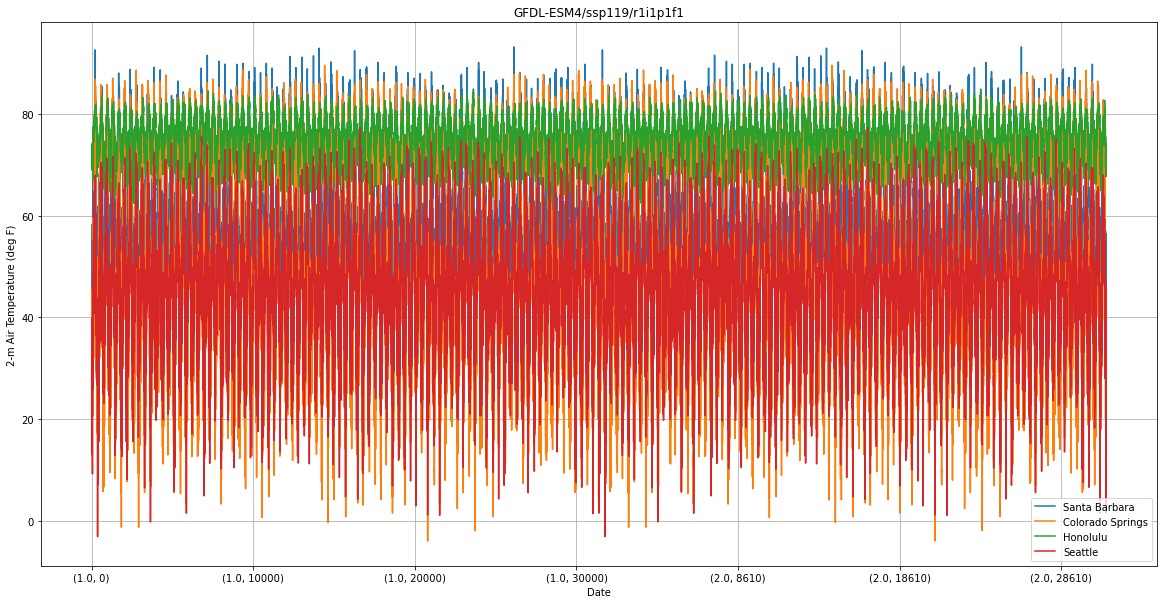

In [21]:
ax = df_f[['Santa Barbara', 'Colorado Springs', 'Honolulu', 'Seattle']].plot(figsize=(20, 10), title="GFDL-ESM4/ssp119/r1i1p1f1", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()